In [271]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import (
    FunctionTransformer,
    RobustScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder   
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest, RandomForestRegressor
import optuna
import datetime as dt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression

In [272]:

colors = ['#2752ee',
          '#024b6f', 
          '#1bb4fa', 
          '#01295f',
          '#1bb4fa',
          '#b2eef2',
          '#e44c03']
px.imshow(colors)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [273]:
df = pd.read_excel('../data/Real estate valuation data set.xlsx', index_col='No')

In [274]:
df.columns

Index(['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [275]:
pattern = re.compile(r'X(\d+)\s|Y\s')
df.columns = list(map(lambda x: 
                            pattern.sub('', x)
                            .lower().replace(' ', '_'),
                    df.columns.values))



In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 1 to 414
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_date                     414 non-null    float64
 1   house_age                            414 non-null    float64
 2   distance_to_the_nearest_mrt_station  414 non-null    float64
 3   number_of_convenience_stores         414 non-null    int64  
 4   latitude                             414 non-null    float64
 5   longitude                            414 non-null    float64
 6   house_price_of_unit_area             414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


In [277]:
df.reset_index(inplace=True)
df.drop(columns='No', inplace=True)

In [278]:
df['transaction_date'] = df['transaction_date'].copy().astype('int')

In [279]:
df.nunique()

transaction_date                         2
house_age                              236
distance_to_the_nearest_mrt_station    259
number_of_convenience_stores            11
latitude                               234
longitude                              232
house_price_of_unit_area               270
dtype: int64

In [280]:
metadata = {
    'tgt': set(['house_price_of_unit_area']),
    'num_fts': set(df.select_dtypes(include='number').columns.tolist()),
}
metadata

{'tgt': {'house_price_of_unit_area'},
 'num_fts': {'distance_to_the_nearest_mrt_station',
  'house_age',
  'house_price_of_unit_area',
  'latitude',
  'longitude',
  'number_of_convenience_stores',
  'transaction_date'}}

In [281]:
metadata['num_fts'] - metadata['tgt']

{'distance_to_the_nearest_mrt_station',
 'house_age',
 'latitude',
 'longitude',
 'number_of_convenience_stores',
 'transaction_date'}

In [282]:
X_train, X_test, y_train, y_test = train_test_split(
    df[list(metadata['num_fts'] - metadata['tgt'])],
    df[list(metadata['tgt'])],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [283]:
print(
    'Training data shape:', X_train.shape, y_train.shape,
    '\nTesting data shape:', X_test.shape, y_test.shape
)

Training data shape: (331, 6) (331, 1) 
Testing data shape: (83, 6) (83, 1)


In [284]:
scaler = RobustScaler()

num_pl = Pipeline(steps=[
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pl, list(metadata['num_fts']-metadata['tgt']))
])

baseline_trainer = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


In [285]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['house_age', 'transaction_date',
                                  'number_of_convenience_stores', 'longitude',
                                  'distance_to_the_nearest_mrt_station',
                                  'latitude'])])

In [286]:
preprocessor.get_feature_names_out()

array(['num__house_age', 'num__transaction_date',
       'num__number_of_convenience_stores', 'num__longitude',
       'num__distance_to_the_nearest_mrt_station', 'num__latitude'],
      dtype=object)

In [287]:
baseline_trainer.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['house_age',
                                                   'transaction_date',
                                                   'number_of_convenience_stores',
                                                   'longitude',
                                                   'distance_to_the_nearest_mrt_station',
                                                   'latitude'])])),
                ('model', LinearRegression())])

In [288]:
y_train_pred = baseline_trainer.predict(X_train)
y_test_pred = baseline_trainer.predict(X_test)

In [289]:
baseline_results = pd.DataFrame(
    data ={
        'train': {
            'r2': r2_score(y_train, y_train_pred),
            'mse': mean_squared_error(y_train, y_train_pred),
            'mae': mean_absolute_error(y_train, y_train_pred),
            'rmse': mean_squared_error(y_train, y_train_pred, squared=False)
        },
        'test': {
            'r2': r2_score(y_test, y_test_pred),
            'mse': mean_squared_error(y_test, y_test_pred),
            'mae': mean_absolute_error(y_test, y_test_pred),
            'rmse': mean_squared_error(y_test, y_test_pred, squared=False)
        }
    }
)
baseline_results = baseline_results.T.reset_index().rename(columns={'index': 'dataset'})

/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [290]:
baseline_results

,dataset,r2,mse,mae,rmse
0,train,0.553183,84.042017,6.360268,9.167443
1,test,0.695270,51.121348,5.133446,7.149919


In [291]:
melted_df = baseline_results.melt(id_vars='dataset', var_name='metric', value_name='score')
melted_df

,dataset,metric,score
0,train,r2,0.553183
1,test,r2,0.695270
2,train,mse,84.042017
3,test,mse,51.121348
4,train,mae,6.360268
5,test,mae,5.133446
6,train,rmse,9.167443
7,test,rmse,7.149919


In [292]:
baseline_pfm_fig = px.bar(
    melted_df,
    y=melted_df["metric"].apply(lambda x: x.upper()),
    x="score",
    color="dataset",
    barmode="group",
    color_discrete_map={"train": colors[3], "test": colors[4]},
    title="Baseline Model Performance",
)
baseline_pfm_fig.update_layout(
    template="plotly_white",
    xaxis_title="Score",
    yaxis_title="Metric",
    legend_title="Dataset",
    font=dict(family="Georgia", size=14, color="black"),
    width=1200,
    height=600,
)

In [293]:
df.drop(columns=metadata['tgt'])

,transaction_date,house_age,distance_to_the_nearest_mrt_station,number_of_convenience_stores,latitude,longitude
0,2012,32.0,84.87882,10,24.98298,121.54024
1,2012,19.5,306.59470,9,24.98034,121.53951
2,2013,13.3,561.98450,5,24.98746,121.54391
3,2013,13.3,561.98450,5,24.98746,121.54391
4,2012,5.0,390.56840,5,24.97937,121.54245
...,...,...,...,...,...,...
409,2013,13.7,4082.01500,0,24.94155,121.50381
410,2012,5.6,90.45606,9,24.97433,121.54310
411,2013,18.8,390.96960,7,24.97923,121.53986
412,2013,8.1,104.81010,5,24.96674,121.54067


In [294]:
dim_reducer = PCA(n_components=3)
pca_df = pd.DataFrame(
    data=dim_reducer.fit_transform(df.drop(columns=metadata['tgt'])),
    columns=dim_reducer.get_feature_names_out()
)
pca_df

,pca0,pca1,pca2
0,-999.010859,14.593938,4.245091
1,-777.296689,2.032526,3.777447
2,-521.902952,-4.287548,0.247361
3,-521.902952,-4.287548,0.247361
4,-693.320803,-12.552818,0.151182
...,...,...,...
409,2998.131098,-4.702575,0.204449
410,-993.438324,-11.820655,3.716850
411,-692.919218,1.282050,1.909296
412,-979.078090,-9.392298,-0.305936


In [295]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    pca_df,
    df[list(metadata['tgt'])],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [296]:
print(
    'Training data shape:', X_pca_train.shape, y_pca_train.shape,
    '\nTesting data shape:', X_pca_test.shape, y_pca_test.shape
)

Training data shape: (331, 3) (331, 1) 
Testing data shape: (83, 3) (83, 1)


In [297]:
baseline_trainer_pca = Pipeline(steps=[
    ('sclaler', RobustScaler()),
    ('model', LinearRegression())
])
baseline_trainer_pca.fit(X_pca_train, y_pca_train)

Pipeline(steps=[('sclaler', RobustScaler()), ('model', LinearRegression())])

In [298]:
y_pca_train_pred = baseline_trainer_pca.predict(X_pca_train)
y_pca_test_pred = baseline_trainer_pca.predict(X_pca_test)

In [299]:
baseline_pca_results = pd.DataFrame(
    data={
        'train': {
            'r2': r2_score(y_pca_train, y_pca_train_pred),
            'mse': mean_squared_error(y_pca_train, y_pca_train_pred),
            'mae': mean_absolute_error(y_pca_train, y_pca_train_pred),
            'rmse': mean_squared_error(y_pca_train, y_pca_train_pred, squared=False)
        },
        'test': {
            'r2': r2_score(y_pca_test, y_pca_test_pred),
            'mse': mean_squared_error(y_pca_test, y_pca_test_pred),
            'mae': mean_absolute_error(y_pca_test, y_pca_test_pred),
            'rmse': mean_squared_error(y_pca_test, y_pca_test_pred, squared=False)
        }
    }
)
baseline_pca_results = baseline_pca_results.T.reset_index().rename(columns={'index': 'dataset'})
baseline_pca_results

/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



,dataset,r2,mse,mae,rmse
0,train,0.514643,91.291016,6.721150,9.554633
1,test,0.648972,58.888405,5.632391,7.673878


In [300]:
melted_pca_df = baseline_pca_results.melt(id_vars='dataset', var_name='metric', value_name='score')

In [301]:
baseline_pca_pfm_fig = px.bar(
    melted_pca_df,
    y=melted_pca_df["metric"].apply(lambda x: x.upper()),
    x="score",
    color="dataset",
    barmode="group",
    color_discrete_map={"train": colors[3], "test": colors[4]},
    title="Baseline Model Performance with PCA",
)

baseline_pca_pfm_fig.update_layout(
    template="plotly_white",
    xaxis_title="Score",
    yaxis_title="Metric",
    legend_title="Dataset",
    font=dict(family="Georgia", size=14, color="black"),
    width=1200,
    height=600,
)

In [302]:
fig = make_subplots(2, 1, subplot_titles=("Baseline Model Performance", "Baseline Model Performance with PCA"), vertical_spacing=0.15, shared_xaxes=True)

for trace in baseline_pfm_fig.data:
    trace['showlegend'] = True
    fig.add_trace(trace, 1, 1)
    
for trace in baseline_pca_pfm_fig.data:
    fig.add_trace(trace, 2, 1)

fig.update_layout(
    title='Model Performance Comparison',
    template="plotly_white",
    font=dict(family="Georgia", size=14, color="black"),
    width=1200,
    height=600,
)

In [303]:
iris_df = load_iris(as_frame=True).frame
iris_df.columns = list(map(lambda x: x.replace(' (cm)', '').replace(' ','_'), iris_df.columns))
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [304]:
iris_X = iris_df.drop(columns='target')
iris_y = iris_df['target']

iris_X = pd.DataFrame(
    data=dim_reducer.fit_transform(iris_X),
    columns=dim_reducer.get_feature_names_out()
)
X_train, X_test, y_train, y_test = train_test_split(
    iris_X,
    iris_y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [305]:
print(
    'Training data shape:', X_train.shape, y_train.shape,
    '\nTesting data shape:', X_test.shape, y_test.shape
)

Training data shape: (120, 3) (120,) 
Testing data shape: (30, 3) (30,)


In [306]:
baseline_clf = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('model', LogisticRegression())
])

baseline_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('model', LogisticRegression())])

In [307]:
y_train_pred = baseline_clf.predict(X_train)
y_test_pred = baseline_clf.predict(X_test)

In [337]:
print('Training Classification Report\n', classification_report(y_train, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred)
cm_train_fig = px.imshow(cm, color_continuous_scale=['white' ,colors[4], colors[0]], text_auto=True)
cm_train_fig.update_layout(
    template='plotly_white',
    title='Training Confusion Matrix',
    width=400,
    height=400,
    font=dict(family='Georgia', size=14, color='black')
)

Training Classification Report
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.85      0.83      0.84        41
           2       0.83      0.87      0.85        39

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



In [336]:
print('Testing Classification Report\n', classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
cm_test_fig = px.imshow(cm, color_continuous_scale=['white' ,colors[4], colors[0]], text_auto=True)
cm_test_fig.update_layout(
    template='plotly_white',
    title='Testing Confusion Matrix',
    width=400,
    height=400,
    font=dict(family='Georgia', size=14, color='black')
)

Testing Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.89      0.89      0.89         9
           2       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [310]:
baseline_clf.named_steps['model'].penalty = 'l2'
baseline_clf.named_steps['model']

LogisticRegression()

In [311]:
baseline_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('model', LogisticRegression())])

In [312]:
reg_y_train_pred = baseline_clf.predict(X_train)
reg_y_test_pred = baseline_clf.predict(X_test)

In [313]:
print('Training Classification Report\n', classification_report(y_train, reg_y_train_pred))
print('Testing Classification Report\n', classification_report(y_test, reg_y_test_pred))


Training Classification Report
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.85      0.83      0.84        41
           2       0.83      0.87      0.85        39

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120

Testing Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.89      0.89      0.89         9
           2       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [334]:
cm_fig = make_subplots(1, 4, subplot_titles=('Training Confusion Matrix', 'Applying L2 Regularization', 'Testing Confusion Matrix', 'Applying L2 Regularization'), vertical_spacing=0.15, shared_yaxes=True)
cm_fig.add_trace(cm_train_fig.data[0], 1, 1)
cm_fig.add_trace(px.imshow(confusion_matrix(y_train, reg_y_train_pred), text_auto=True).data[0], 1, 2)
cm_fig.add_trace(cm_test_fig.data[0], 1, 3)
cm_fig.add_trace(px.imshow(confusion_matrix(y_test, reg_y_test_pred), text_auto=True).data[0], 1, 4)
cm_fig.update_layout(
    template='plotly_white',
    font={
        'family': 'Georgia',
        'size': 14,
        'color': 'black'
    },
    coloraxis_colorbar=dict(title='Count'),
    coloraxis=dict(colorscale=['white' ,colors[4], colors[0]]),
)
cm_fig.show()
    

In [318]:
print(cm_train_fig)

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: %{z}<extra></extra>',
              'name': '0',
              'texttemplate': '%{z}',
              'type': 'heatmap',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[39,  1,  0],
                          [ 0, 34,  7],
                          [ 0,  5, 34]])}],
    'layout': {'coloraxis': {'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                            'rgb(222,235,247)'], [0.25,
                                            'rgb(198,219,239)'], [0.375,
                                            'rgb(158,202,225)'], [0.5,
                                            'rgb(107,174,214)'], [0.625,
                                            'rgb(66,146,198)'], [0.75,
                                            'rgb(33,113,181)'], [0.875,
                                            'rgb(8,81,156)'], [1.0,
           

# Extended section

In [ ]:
tsne = TSNE(n_components=3)

df_tsne = pd.DataFrame(
    data=tsne.fit_transform(df[metadata['num_fts']]),
    columns=tsne.get_feature_names_out()
)

TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [ ]:
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    opacity=0.5,
)
fig.show()

In [ ]:
scaler = RobustScaler()
isf = IsolationForest(contamination=0.1, random_state=42)
outliers = isf.fit_predict(scaler.fit_transform(df.drop(columns=metadata['tgt'])))
outliers

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
       -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
df_tsne['outliers'] = outliers.astype(str)
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    color='outliers',
    color_discrete_map={
        '-1': 'red',
        '1': 'grey'
    }
)
fig.show()

In [ ]:
mask = outliers == 1
df = df.loc[mask, :].copy()

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:,:-1], df.loc[:,metadata['tgt']], test_size=0.2, random_state=42, stratify=df['transaction_date'])    

In [ ]:
mean_squared_error(y_train, y_train_pred)

84.04201688790916

In [ ]:
# custom transformer that uses a KMeans clusterer in the fit() method to identify the main clusters in the training data, and 
# then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center:

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return cosine_similarity(X, self.kmeans_.cluster_centers_)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
clust.kmeans_.cluster_centers_

array([[ 24.96580621, 121.54178224],
       [ 24.96420389, 121.51411639],
       [ 24.98293194, 121.53704774],
       [ 24.94376357, 121.50141143],
       [ 24.95252182, 121.55061364],
       [ 24.97412762, 121.53418548],
       [ 24.95553056, 121.53701611],
       [ 24.97330111, 121.54515278],
       [ 24.981938  , 121.524512  ],
       [ 24.98083391, 121.54323391]])

In [ ]:
import numpy as np

# Function to calculate Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Sample data
coords = np.array([
    [24.9809, 121.547],
    [24.9805, 121.538],
    [24.9774, 121.545],
    [24.9415, 121.504],
    [24.9667, 121.541]
])

# Calculate Haversine distance matrix
n = coords.shape[0]
haversine_dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        haversine_dist_matrix[i, j] = haversine(coords[i, 0], coords[i, 1], coords[j, 0], coords[j, 1])

print("Haversine Distance Matrix:")
print(haversine_dist_matrix)

# Function to calculate RBF kernel from distance matrix
def rbf_kernel_from_distances(dist_matrix, sigma):
    return np.exp(-dist_matrix**2 / (2 * sigma**2))

# Specify sigma
sigma = 1.0  # You may need to tune this parameter

# Calculate RBF kernel matrix from Haversine distance matrix
rbf_kernel_matrix = rbf_kernel()

print("RBF Kernel Matrix:")
print(rbf_kernel_matrix)


Haversine Distance Matrix:
[[0.         0.90822362 0.43829268 6.1631243  1.69083132]
 [0.90822362 0.         0.78526045 5.52755517 1.56400208]
 [0.43829268 0.78526045 0.         5.74618944 1.25624816]
 [6.1631243  5.52755517 5.74618944 0.         4.66537612]
 [1.69083132 1.56400208 1.25624816 4.66537612 0.        ]]
RBF Kernel Matrix:
[[1.00000000e+00 6.62036182e-01 9.08418377e-01 5.64751292e-09
  2.39439314e-01]
 [6.62036182e-01 1.00000000e+00 7.34682396e-01 2.31906152e-07
  2.94330718e-01]
 [9.08418377e-01 7.34682396e-01 1.00000000e+00 6.76210466e-08
  4.54262650e-01]
 [5.64751292e-09 2.31906152e-07 6.76210466e-08 1.00000000e+00
  1.87772004e-05]
 [2.39439314e-01 2.94330718e-01 4.54262650e-01 1.87772004e-05
  1.00000000e+00]]


In [ ]:
print(Xtrain[['latitude', 'longitude']].head(5).to_markdown())

|     |   latitude |   longitude |
|----:|-----------:|------------:|
| 115 |    24.9809 |     121.547 |
| 174 |    24.9805 |     121.538 |
|  16 |    24.9774 |     121.545 |
| 298 |    24.9415 |     121.504 |
| 412 |    24.9667 |     121.541 |


In [ ]:
clust = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42)
clust.fit(Xtrain[['latitude', 'longitude']])
trsf_geo = clust.transform(Xtrain[['latitude', 'longitude']])
trsf_geo

array([[0.99999999, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99999999, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.99999999, ..., 1.        , 0.99999999,
        0.99999999],
       [1.        , 1.        , 0.99999999, ..., 1.        , 0.99999999,
        0.99999999]])

In [ ]:
def log_transformer():
    return FunctionTransformer(
        np.log1p,
        feature_names_out='one-to-one'
    )

num_pl = Pipeline(steps=[
    ('scaling',RobustScaler())
])

cat_pl = Pipeline(steps=[
    ('ordinal', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pl, ['house_age', 'distance_to_the_nearest_mrt_station']),
    ('cat', cat_pl, ['transaction_date']),
    ('geo', ClusterSimilarity(n_clusters=5, gamma=0.1), ['latitude', 'longitude']),
    ('log', Pipeline(steps=[
            ('log', log_transformer()),
            ('scaling', RobustScaler())
        ]), ['distance_to_the_nearest_mrt_station'])
])

preprocessor.fit(Xtrain)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaling', RobustScaler())]),
                                 ['house_age',
                                  'distance_to_the_nearest_mrt_station']),
                                ('cat',
                                 Pipeline(steps=[('ordinal', OneHotEncoder())]),
                                 ['transaction_date']),
                                ('geo',
                                 ClusterSimilarity(gamma=0.1, n_clusters=5),
                                 ['latitude', 'longitude']),
                                ('log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaling', RobustScaler())]),
                                 ['distance_to_the_nearest_mrt_station'])])

In [ ]:
preprocessor.get_feature_names_out()

array(['num__house_age', 'num__distance_to_the_nearest_mrt_station',
       'cat__transaction_date_2012', 'cat__transaction_date_2013',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity',
       'log__distance_to_the_nearest_mrt_station'], dtype=object)

In [ ]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', XGBRegressor(enable_categorical=True))
])

In [ ]:
Xtrain

,transaction_date,house_age,distance_to_the_nearest_mrt_station,number_of_convenience_stores,latitude,longitude
115,2013,20.6,737.9161,2,24.98092,121.54739
174,2013,4.3,432.0385,7,24.98050,121.53778
16,2013,0.0,292.9978,6,24.97744,121.54458
298,2013,16.7,4082.0150,0,24.94155,121.50381
412,2013,8.1,104.8101,5,24.96674,121.54067
...,...,...,...,...,...,...
71,2013,35.5,640.7391,3,24.97563,121.53715
177,2013,33.0,181.0766,9,24.97697,121.54262
124,2012,9.9,279.1726,7,24.97528,121.54541
389,2013,40.9,122.3619,8,24.96756,121.54230


In [ ]:
full_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['house_age',
                                                   'distance_to_the_nearest_mrt_station']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OneHotEncoder())]),
                                                  ['transaction_date']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=0.1,
                                                                    n_clusters=5),
                                                  ['latitude', 'longitude']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   F...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_train_pred = full_pipeline.predict(Xtrain)
print(r2_score(ytrain, y_train_pred))

0.9891673530032997


In [ ]:
y_test_pred = full_pipeline.predict(Xtest)
print(r2_score(ytest, y_test_pred))

0.5136439694889336


In [ ]:
lin_pl = Pipeline(steps=[
    ('scaling', RobustScaler()),
    ('model', LinearRegression())
])
lin_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('scaling', RobustScaler()), ('model', LinearRegression())])

In [ ]:
y_train_pred = lin_pl.predict(Xtrain)
print(r2_score(ytrain, y_train_pred))

0.5401967286725331


In [ ]:
y_test_pred = lin_pl.predict(Xtest)
print(r2_score(ytest, y_test_pred))

0.6422034118208824


In [ ]:
scores = cross_val_score(
    cv=KFold(shuffle=True, random_state=42),
    estimator=lin_pl,
    scoring='neg_root_mean_squared_error',
    X=Xtrain,
    y=ytrain
)

(2.2190988793642323, -9.08139508202047)

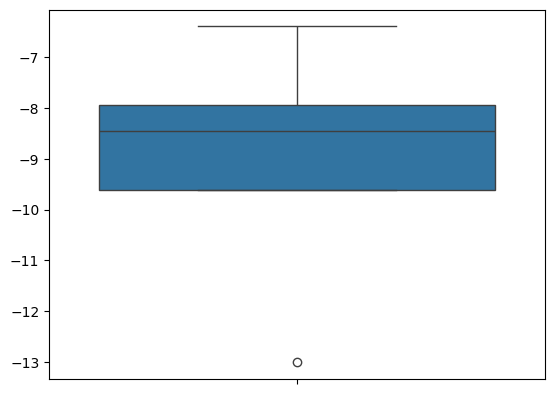

In [ ]:
sns.boxplot(scores)
np.std(scores), np.mean(scores)

In [ ]:
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR(),
    RandomForestRegressor(),
    XGBRegressor()
]

In [ ]:
from sklearn.metrics import make_scorer


lin_models = {
    model.__class__.__name__: cross_val_score(
        cv=KFold(shuffle=True, random_state=42, n_splits=10),
        estimator=Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ]),
        scoring='neg_root_mean_squared_error',
        X=Xtrain,
        y=ytrain,
        n_jobs=-1
    )
    for model in models
}

In [ ]:
df = pd.DataFrame(
data=lin_models
)

In [ ]:
df

,LinearRegression,Lasso,Ridge,SVR,RandomForestRegressor,XGBRegressor
0,-3.907654,-6.068201,-5.181699,-6.496816,-4.733881,-5.373402
1,-6.227390,-8.643266,-7.756632,-7.995831,-4.974592,-4.142746
2,-15.573653,-15.564142,-15.227743,-15.327408,-15.010807,-15.433377
3,-9.200144,-11.029407,-10.169371,-10.411493,-8.111635,-7.378695
4,-8.274060,-9.302623,-9.036949,-9.239972,-6.878125,-9.430143
5,-6.097272,-5.600986,-6.097625,-5.748632,-5.333547,-5.207040
6,-5.491592,-5.989620,-6.173876,-6.139739,-5.628094,-7.690811
7,-7.991309,-8.935981,-8.992010,-8.157869,-8.160479,-9.567758
8,-8.314299,-9.113152,-8.946390,-9.180278,-10.160866,-10.335267
9,-9.626995,-10.555222,-9.879398,-10.742104,-7.802094,-9.258235


<Axes: xlabel='house_price_of_unit_area', ylabel='Count'>

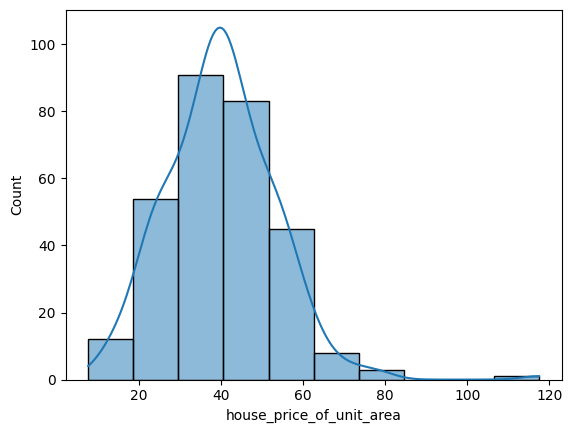

In [ ]:
sns.histplot(ytrain, kde=True, bins=10)

<Axes: >

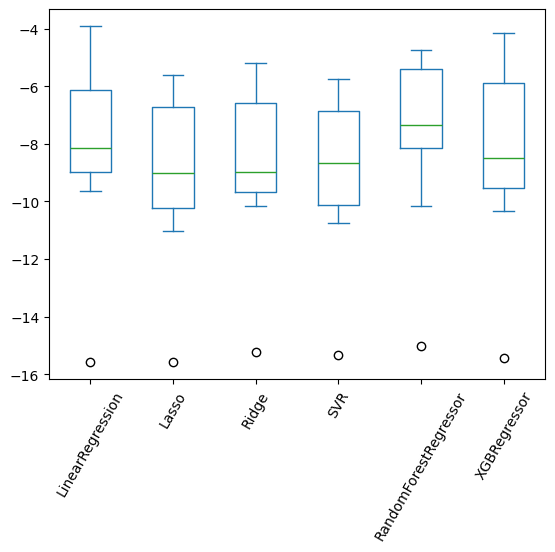

In [ ]:
df.plot(kind='box', rot=60)

# Tuning Ridge

In [ ]:
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.1, 1.0),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
        'random_state': 42,
        'max_iter': trial.suggest_int('max_iter', 1000, 10000),
    }

    model = Ridge(**params)
    scores = cross_val_score(
        cv=KFold(shuffle=True, random_state=42, n_splits=10),
        estimator=Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]),
        scoring='neg_root_mean_squared_error',
        X=Xtrain,
        y=ytrain,
        n_jobs=-1
    )
    return np.mean(scores)

study = optuna.create_study(direction='minimize', study_name='Ridge',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)


[I 2024-05-30 12:21:31,382] A new study created in memory with name: Ridge
[I 2024-05-30 12:21:31,470] Trial 0 finished with value: -8.74779496636366 and parameters: {'alpha': 0.4370861069626263, 'solver': 'auto', 'tol': 0.0006051038616257768, 'max_iter': 7373}. Best is trial 0 with value: -8.74779496636366.
[I 2024-05-30 12:21:31,531] Trial 1 finished with value: -8.748802093800423 and parameters: {'alpha': 0.1185260448662222, 'solver': 'auto', 'tol': 0.00043762556845569465, 'max_iter': 3621}. Best is trial 1 with value: -8.748802093800423.
[I 2024-05-30 12:21:31,587] Trial 2 finished with value: -8.747127591482496 and parameters: {'alpha': 0.6506676052501416, 'solver': 'sparse_cg', 'tol': 0.0005964904231734221, 'max_iter': 1418}. Best is trial 1 with value: -8.748802093800423.
[I 2024-05-30 12:21:31,631] Trial 3 finished with value: -8.747138947967661 and parameters: {'alpha': 0.6467903667112945, 'solver': 'lsqr', 'tol': 0.0006873906962470354, 'max_iter': 4961}. Best is trial 1 with 

In [ ]:
ridge_best_params = study.best_params

In [ ]:
optmized_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(**ridge_best_params))
])
optmized_ridge.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['house_age',
                                                   'distance_to_the_nearest_mrt_station']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OneHotEncoder())]),
                                                  ['transaction_date']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=0.1,
                                                                    n_clusters=5),
                                                  ['latitude', 'longitude']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['distance_to_the_nearest_mrt_station'])])),
                ('model',
                 Ridge(alpha=0.10013702527037004, max_iter=8591,
                       tol=0.0007492121997198124))])

In [ ]:
optmized_ridge.score(Xtrain, ytrain)

0.5421596634202968

In [ ]:
print(r2_score(ytrain, optmized_ridge.predict(Xtrain)))

0.5421596634202968


In [ ]:
print(r2_score(ytest, optmized_ridge.predict(Xtest)))

0.6177273025407408


# Tuning SVR

In [ ]:
def objective(trial):
    params ={
        'epsilon': trial.suggest_float('epsilon', 0.5, 1.0, log=True),
        'C': trial.suggest_float('C', 0.5, 1.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    }
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR(**params))
    ])
    full_pipeline.fit(Xtrain, ytrain)
    
    
    return r2_score(ytrain, full_pipeline.predict(Xtrain))

study = optuna.create_study(direction='maximize', study_name='SVR',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=500)

[I 2024-05-30 12:21:36,914] A new study created in memory with name: SVR
[I 2024-05-30 12:21:36,929] Trial 0 finished with value: 0.5302802742645245 and parameters: {'epsilon': 0.6482131165247735, 'C': 0.9664147012279757, 'kernel': 'linear'}. Best is trial 0 with value: 0.5302802742645245.
[I 2024-05-30 12:21:36,943] Trial 1 finished with value: 0.23543067769123083 and parameters: {'epsilon': 0.520540966199949, 'C': 0.9114125527116832, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.5302802742645245.
[I 2024-05-30 12:21:36,955] Trial 2 finished with value: 0.3640145103304836 and parameters: {'epsilon': 0.8903488639350978, 'C': 0.5792825495506346, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.5302802742645245.
[I 2024-05-30 12:21:36,968] Trial 3 finished with value: 0.5296496229017732 and parameters: {'epsilon': 0.6745255603940726, 'C': 0.6118411902896104, 'kernel': 'linear'}. Best is trial 0 with value: 0.5302802742645245.
[I 2024-05-30 12:21:36,983] Trial 4 finished with val

In [ ]:
best_svr_params = study.best_params
best_svr_params

{'epsilon': 0.8788666407083235, 'C': 0.9996581253500122, 'kernel': 'poly'}

In [ ]:
best_svr_params = study.best_params
opt_svr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(**best_svr_params))
])
opt_svr.fit(Xtrain, ytrain)
print('r2 score on train set: ',r2_score(ytrain, opt_svr.predict(Xtrain)))
print('r2 score on test set',r2_score(ytest, opt_svr.predict(Xtest)))

r2 score on train set:  0.5682019886428633
r2 score on test set 0.6793435910235994


In [ ]:
preprocessor.fit_transform(Xtrain)

array([[ 0.29347826,  0.39922159,  0.        , ...,  0.99986135,
         0.99999736,  0.37288806],
       [-0.5923913 , -0.04191477,  0.        , ...,  0.99991745,
         0.99999779, -0.05160233],
       [-0.82608696, -0.24243913,  0.        , ...,  0.99988968,
         0.99999903, -0.35923473],
       ...,
       [-0.28804348, -0.26237782,  1.        , ...,  0.99988981,
         0.99999716, -0.39749784],
       [ 1.39673913, -0.48853005,  0.        , ...,  0.99991945,
         0.99998531, -1.04912586],
       [-0.11956522,  0.04489522,  1.        , ...,  0.99994584,
         0.99997635,  0.05178926]])

In [ ]:
trsf_df = pd.DataFrame(
    data=preprocessor.transform(Xtrain),
    columns=preprocessor.get_feature_names_out()
)
trsf_df

,num__house_age,num__distance_to_the_nearest_mrt_station,cat__transaction_date_2012,cat__transaction_date_2013,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,log__distance_to_the_nearest_mrt_station
0,0.293478,0.399222,0.0,1.0,0.999978,0.999651,0.999964,0.999861,0.999997,0.372888
1,-0.592391,-0.041915,0.0,1.0,0.999996,0.999733,0.999966,0.999917,0.999998,-0.051602
2,-0.826087,-0.242439,0.0,1.0,0.999987,0.999700,0.999977,0.999890,0.999999,-0.359235
3,0.081522,5.222078,0.0,1.0,0.999796,0.999999,0.999808,0.999938,0.999706,1.730830
4,-0.385870,-0.513843,0.0,1.0,0.999987,0.999793,0.999998,0.999929,0.999983,-1.171046
...,...,...,...,...,...,...,...,...,...,...
292,1.103261,0.259073,0.0,1.0,0.999999,0.999771,0.999980,0.999934,0.999996,0.260877
293,0.967391,-0.403852,0.0,1.0,0.999992,0.999720,0.999979,0.999902,0.999999,-0.739864
294,-0.288043,-0.262378,1.0,0.0,0.999986,0.999707,0.999983,0.999890,0.999997,-0.397498
295,1.396739,-0.488530,0.0,1.0,0.999986,0.999776,0.999998,0.999919,0.999985,-1.049126


<Axes: title={'center': 'Transformed Features'}>

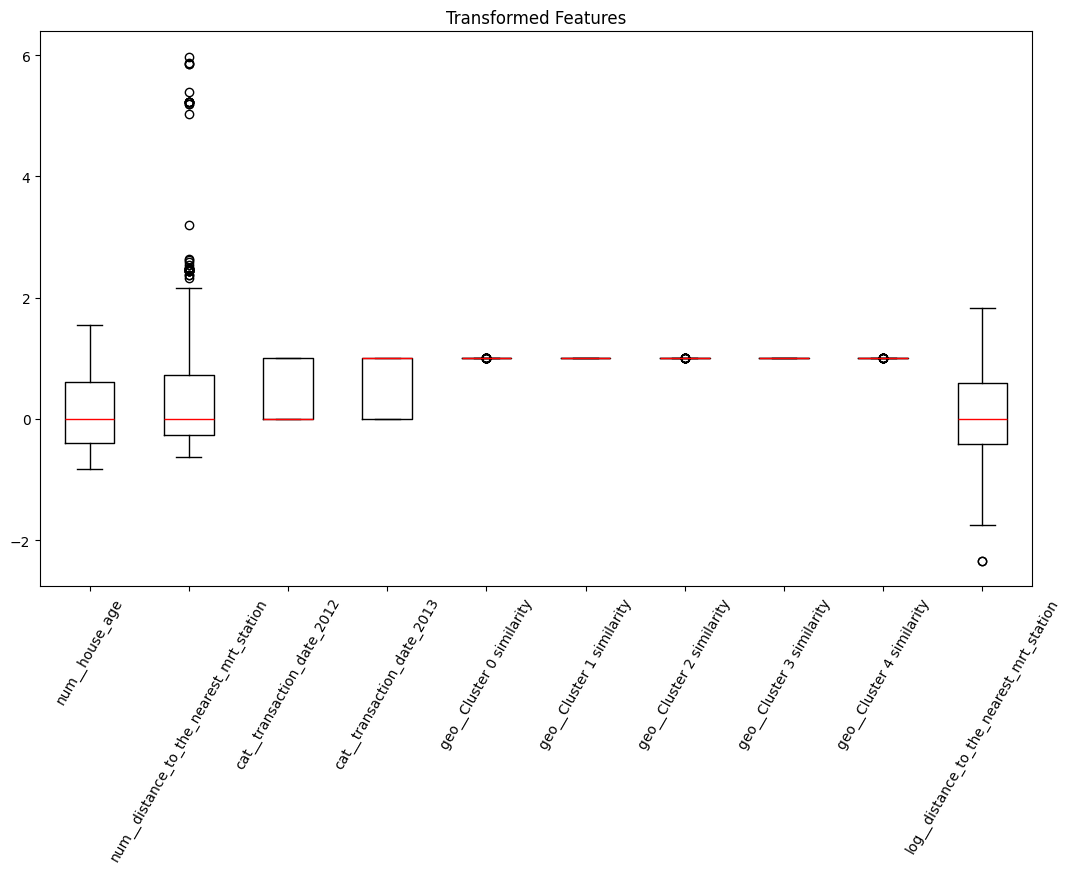

In [ ]:
trsf_df.plot(kind='box', rot = 60, figsize=(12.8,7.2), title='Transformed Features', color=dict(boxes='black', whiskers='black', medians='red', caps='black'))

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
# fig = px.scatter_mapbox(
#     data_frame=df,
#     lat='latitude',
#     lon='longitude',
#     color='house_price_of_unit_area',
#     zoom=10,
#     center=dict(lat=df['latitude'].median(), lon=df['longitude'].median()),
#     mapbox_style='carto-positron'
# )
# fig.update_layout(
#     width=1280,
#     height=720,
#     margin=dict(l=0, r=0, t=0, b=0)
# )
# fig.add_trace(go.Scattermapbox(
#     lat=k_centroids['lat'],
#     lon=k_centroids['lon'],
#     mode='markers',
#     marker=dict(size=20, color='red'),
# ))
# fig.show()